# The Future of Market Sentiment

Using classical technical analysis which tends to focus on the market sentiment 
of the moment we apply modern deep learning to see the near-term future and attempt
avoid misfires.

Our algorithm of choice, DeepAR, enables forecasting on very large datasets composed of multiple 
timeseries. This is a typical investment portfolio. Unlike other forecasting algorithms such as 
EMS, Prophet, and ARIMA, DeepAR uses a deep learning encoder/decoder model to discover behavioral
relationships in the data that are otherwise inaccessible. We expect this model to yeild non-intuitive 
results that are specifically relevant to the instruments in our basket.

In [1]:
import os
import json
import boto3
import sagemaker
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

%matplotlib inline

/Users/skrinak/miniconda3/envs/sagemaker/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Add symbols to your portfolio

In [2]:
portfolio = ('AMZN', 'GOOG', 'FB', 'AAPL', 'SPY', 'TSLA')

## Other settings

In [3]:
base_job_name = 'sparkSummitDemo'

# Training data range. Choose a minimum 2-year timeframe that best matches current conditions. 
start_date = '2014-01-01'
end_date = '2016-01-01'

s3_bucket = '2021-demos'
s3_prefix = 'sparkSummit'

## Get historical data

Any timeframe can be used to train data. We're living in a time of economic collapes, 
not the first. Recent periods such as the 2008 recession might be a good choice. Ensure that 
the instruments in your portfolio existed at the time period of your training data.

In [4]:
# Get prices for each symbol in time range
portfolio_history = []
for ticker in portfolio: 
    portfolio_history.append(web.DataReader(ticker, data_source = 'yahoo', start=start_date, end=end_date))

## Add indicators to price action history

### Exponential moving averages: 13- and 50-day

EMAs are persistent. We'll need them later.

In [5]:
for ticker in portfolio_history:
    ticker['EMA13'] = ticker.Close.ewm(span=13).mean()
    ticker['EMA50'] = ticker.Close.ewm(span=50).mean()

### MACD - Moving Average Convergence/Divergence

MACD measures trend health. EMAs calculated in MACD are ephemeral. We can toss them once we've calculated the MACD histogram.

In [6]:
for i, ticker in enumerate(portfolio_history):
    EMA12 = ticker.Close.ewm(span=12, adjust=False).mean()
    EMA26 = ticker.Close.ewm(span=26, adjust=False).mean()
    MACD = EMA12-EMA26
    signal = MACD.ewm(span=9, adjust=False).mean()
    portfolio_history[i]['MACDhistogram'] = MACD - signal
    del EMA12, EMA26, MACD

## Slow Stochastics

The poorly-named yet highly-effective "Slow Stochastics" is a trigger indicator. An upward cross in the lower 20% is bullish, a downward cross in the upper 10% is bearish.  Again, All we care about is the fast and slow line. Ephemeral values are tossed aside. 

```
%K = (Current Close - Lowest Low)/(Highest High - Lowest Low) * 100
%D = 3-day SMA of %K
```

* %K is generally called the "slow line", and %D the "fast line"
* Lowest Low = lowest low for the look-back period
* Highest High = highest high for the look-back period

In [7]:
for i, ticker in enumerate(portfolio_history):
    rollingLow, rollingHigh = ticker.Low.rolling(14).min(), ticker.High.rolling(14).max()
    fastLine = 100 * (ticker.Close - rollingLow) / (rollingHigh - rollingLow) 
    slowLine = fastLine.rolling(3).mean()
    portfolio_history[i]['fast_stoch'] = fastLine
    portfolio_history[i]['slow_stoch'] = slowLine

In [8]:
portfolio_history[0].tail()

,High,Low,Open,Close,Volume,Adj Close,EMA13,EMA50,MACDhistogram,fast_stoch,slow_stoch
Date,,,,,,,,,,,
2015-12-24,664.679993,660.599976,663.349976,662.789978,1091200,662.789978,664.229321,638.167861,-2.576272,58.267986,59.044294
2015-12-28,675.500000,665.500000,665.559998,675.200012,3783600,675.200012,665.796563,639.620102,-1.655638,84.543742,67.668843
2015-12-29,696.440002,677.890015,677.979980,693.969971,5735000,693.969971,669.821335,641.751470,0.141280,95.962020,79.591249
2015-12-30,695.489990,686.380005,691.890015,689.070007,3519000,689.070007,672.571146,643.607099,0.882358,87.951615,89.485792
2015-12-31,687.750000,675.890015,686.080017,675.890015,3749600,675.890015,673.045270,644.873095,0.392385,66.405111,83.439582


## Plot the last 100 days

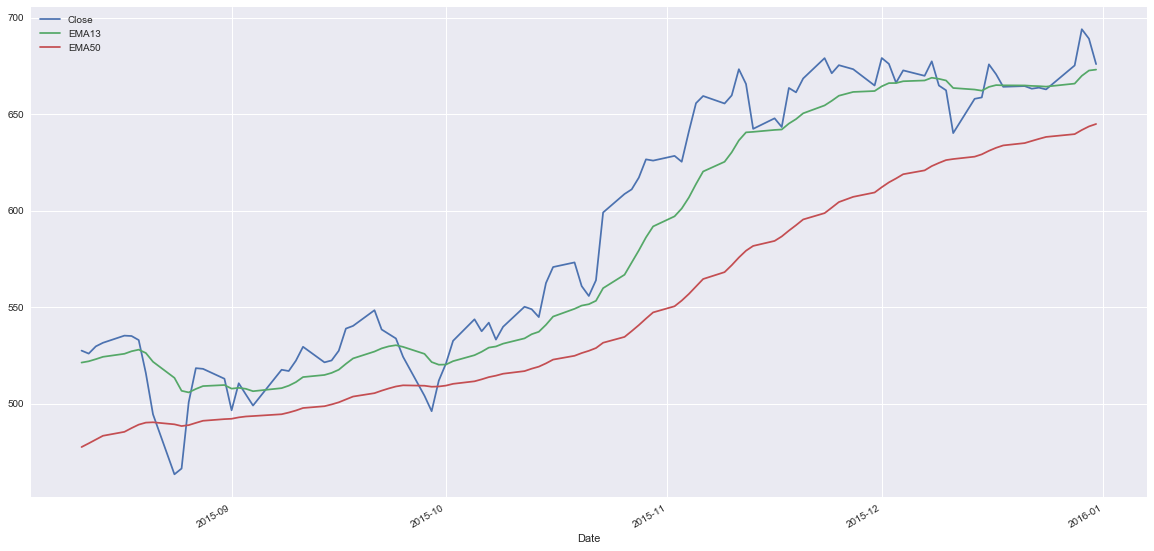

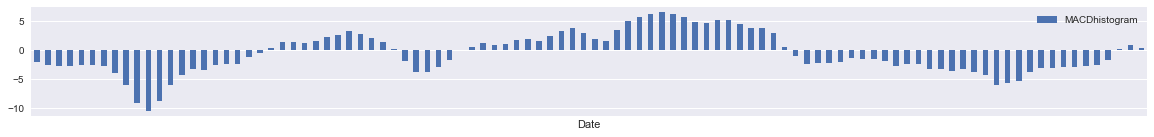

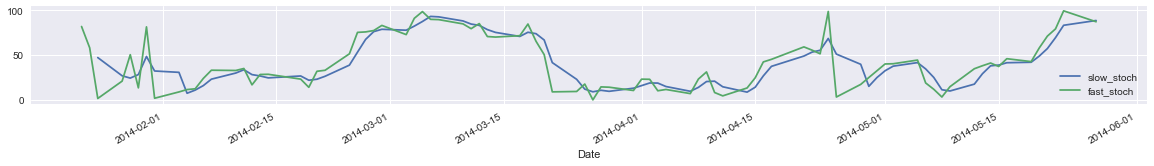

In [9]:
days = 100

plt.style.use('seaborn')

emaCross = portfolio_history[0][['Close', 'EMA13', 'EMA50']].tail(days)
emaCross.plot(figsize=(20,10))

slowStochastic = portfolio_history[0][:days][['slow_stoch', 'fast_stoch']].tail(days)
MACDhistogram = portfolio_history[0][['MACDhistogram']].tail(days)

MACDhistogram.plot(figsize=(20,2), kind='bar', xticks=[])
slowStochastic.plot(figsize=(20,2))

## Format the Training and Test datasets

Use the entire dataset for training. We need to forcast 5 different indicators: 

* The 13-day EMA
* The 50-day EMA
* The MACD Histogram, and
* Both Slow Stochastics indicators

We'll align them on parallel paths as single factor targets. Data will align on the timestamp index. 

In [ ]:
start_date = str(portfolio_history[0].index[0])
start_date

In [ ]:
train_EMA13 = [
    {
        "start": start_date,
        "target": ticker.EMA13.tolist() 
    } for ticker in portfolio_history
]
train_EMA50 = [
    {
        "start": start_date,
        "target": ticker.EMA50.tolist() 
    } for ticker in portfolio_history
]
train_MACDhistogram = [
    {
        "start": start_date,
        "target": ticker.MACDhistogram.tolist() 
    } for ticker in portfolio_history
]

fast_stoch_target = ticker.fast_stoch.dropna()
train_fast_stoch = [
    {
        "start": start_date,
        "target": fast_stoch_target.tolist() 
    } for ticker in portfolio_history
]

slow_stoch_target = ticker.slow_stoch.dropna()
train_slow_stoch = [
    {
        "start": start_date,
        "target": slow_stoch_target.tolist() 
    } for ticker in portfolio_history
]

For the test set we'll use the last 50 values of each indicator.

In [ ]:
periods = 50

test_EMA13 = [
    {
        "start": start_date,
        "target": ticker.EMA13.tail(periods).tolist() 
    } for ticker in portfolio_history
]
test_EMA50 = [
    {
        "start": start_date,
        "target": ticker.EMA50.tail(periods).tolist() 
    } for ticker in portfolio_history
]
test_MACDhistogram = [
    {
        "start": start_date,
        "target": ticker.MACDhistogram.tail(periods).tolist() 
    } for ticker in portfolio_history
]
test_fast_stoch = [
    {
        "start": start_date,
        "target": ticker.fast_stoch.tail(periods).tolist()
    } for ticker in portfolio_history
]
test_slow_stoch = [
    {
        "start": start_date,
        "target": ticker.slow_stoch.tail(periods).tolist() 
    } for ticker in portfolio_history
]

Datasets are prepared. Ship them up to S3.

In [ ]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

write_dicts_to_file("train_EMA13.json", train_EMA13)
write_dicts_to_file("test_EMA13.json", test_EMA13)

write_dicts_to_file("train_EMA50.json", train_EMA50)
write_dicts_to_file("test_EMA50.json", test_EMA50)

write_dicts_to_file("train_MACDhistogram.json", train_MACDhistogram)
write_dicts_to_file("test_MACDhistogram.json", test_MACDhistogram)

write_dicts_to_file("train_fast_stoch.json", train_fast_stoch)
write_dicts_to_file("test_fast_stoch.json", test_fast_stoch)

write_dicts_to_file("train_slow_stoch.json", train_slow_stoch)
write_dicts_to_file("test_slow_stoch.json", test_slow_stoch)

s3 = boto3.resource('s3')
bucket = s3.Bucket(s3_bucket)

for dataset in ['EMA13', 'EMA50', 'MACDhistogram', 'fast_stoch', 'slow_stoch']:
    filename = 'train_' + dataset + '.json'
    with open(filename, 'rb') as data:
        key = s3_prefix + '/data/' + dataset + '/' + filename
        result = bucket.put_object(Key=key, Body=data)
        print('Uploaded file to {}'.format(result))

    filename = 'test_' + dataset + '.json'
    with open(filename, 'rb') as data:
        key = s3_prefix + '/data/' + dataset + '/' + filename
        result = bucket.put_object(Key=key, Body=data)
        print('Uploaded file to {}'.format(result))

## Setup DeepAR in SageMaker

In [ ]:
from sagemaker.predictor import json_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_JSON

sagemaker_session = sagemaker.Session()
role = os.getenv('SAGEMAKER_ROLE')
region = sagemaker_session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

## Training/Testing data parameters

Set the hyperparameters for reuse on every indicator. In the real world we'd create a utility routine to do this. As this is a demo we're explicitly building each predictor. 

In [ ]:
freq = 'D'
context_length = prediction_length = 14

hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "20",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [ ]:
estimator_EMA13 = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=base_job_name + '-EMA13',
    output_path="s3://{}/{}/output/EMA13/train_EMA13.json".format(s3_bucket, s3_prefix)
)
estimator_EMA13.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": "s3://{}/{}/data/EMA13/train_EMA13.json".format(s3_bucket, s3_prefix),
    "test":  "s3://{}/{}/data/EMA13/test_EMA13.json".format(s3_bucket, s3_prefix)
}

estimator_EMA13.fit(inputs=data_channels, wait=False)

estimator_EMA50 = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=base_job_name + '-EMA50',
    output_path="s3://{}/{}/output/EMA50/train_EMA50.json".format(s3_bucket, s3_prefix)
)
estimator_EMA50.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": "s3://{}/{}/data/EMA50/train_EMA50.json".format(s3_bucket, s3_prefix),
    "test":  "s3://{}/{}/data/EMA50/test_EMA50.json".format(s3_bucket, s3_prefix)
}

estimator_EMA50.fit(inputs=data_channels, wait=False)

estimator_MACDhistogram = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=base_job_name + '-MACD',
    output_path="s3://{}/{}/output/MACDhistogram/train_MACDhistogram.json".format(s3_bucket, s3_prefix)
)
estimator_MACDhistogram.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": "s3://{}/{}/data/MACDhistogram/train_MACDhistogram.json".format(s3_bucket, s3_prefix),
    "test":  "s3://{}/{}/data/MACDhistogram/test_MACDhistogram.json".format(s3_bucket, s3_prefix)
}

estimator_MACDhistogram.fit(inputs=data_channels, wait=False)

estimator_fast_stoch = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=base_job_name + '-fast-stoch',
    output_path="s3://{}/{}/output/fast_stoch/train_fast_stoch.json".format(s3_bucket, s3_prefix)
)
estimator_fast_stoch.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": "s3://{}/{}/data/fast_stoch/train_fast_stoch.json".format(s3_bucket, s3_prefix),
    "test":  "s3://{}/{}/data/fast_stoch/test_fast_stoch.json".format(s3_bucket, s3_prefix)
}

estimator_fast_stoch.fit(inputs=data_channels, wait=True)

Wait on this one as well to give the system a chance to catch up.

In [ ]:
estimator_slow_stoch = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=base_job_name + '-slow-stoch',
    output_path="s3://{}/{}/output/slow_stoch/train_slow_stoch.json".format(s3_bucket, s3_prefix)
)
estimator_slow_stoch.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": "s3://{}/{}/data/slow_stoch/train_slow_stoch.json".format(s3_bucket, s3_prefix),
    "test":  "s3://{}/{}/data/slow_stoch/test_slow_stoch.json".format(s3_bucket, s3_prefix)
}

estimator_slow_stoch.fit(inputs=data_channels, wait=True)

In [ ]:
predictor_EMA13 = estimator_EMA13.deploy(
    wait=False,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge')

predictor_EMA50 = estimator_EMA50.deploy(
    wait=False,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge')

predictor_MACDhistogram = estimator_MACDhistogram.deploy(
    wait=False,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge')

predictor_fast_stoch = estimator_fast_stoch.deploy(
    wait=False,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge')

predictor_slow_stoch = estimator_slow_stoch.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge')

## Prepare inference request from holdout set

For prediction we only care about the next 14 days. And, we want a prediction based on current market action. This dataset just like the training set can be tuned. For the demo we're getting the last 70 days. That's just enough to get a full indicator set. 

In [ ]:
from datetime import datetime
from pandas.tseries.offsets import BDay
holdout_start = (datetime.now() - BDay(70)).strftime("%Y-%m-%d")
holdout_end = (datetime.now() - BDay(1)).strftime("%Y-%m-%d")

In [ ]:
holdout_set = []
for ticker in portfolio: 
    holdout_set.append(web.DataReader(ticker, data_source = 'yahoo', start=holdout_start, end=holdout_end))

## Create indicators for the holdout set

In [ ]:
for ticker in holdout_set:
    ticker['EMA13'] = ticker.Close.ewm(span=13).mean()
    ticker['EMA50'] = ticker.Close.ewm(span=50).mean()

for i, ticker in enumerate(holdout_set):
    EMA12 = ticker.Close.ewm(span=12, adjust=False).mean()
    EMA26 = ticker.Close.ewm(span=26, adjust=False).mean()
    MACD = EMA12-EMA26
    signal = MACD.ewm(span=9, adjust=False).mean()
    holdout_set[i]['MACDhistogram'] = MACD - signal
    del EMA12, EMA26, MACD

for i, ticker in enumerate(holdout_set):
    rollingLow, rollingHigh = ticker.Low.rolling(14).min(), ticker.High.rolling(14).max()
    fastLine = 100 * (ticker.Close - rollingLow) / (rollingHigh - rollingLow) 
    slowLine = fastLine.rolling(3).mean()
    holdout_set[i]['fast_stoch'] = fastLine
    holdout_set[i]['slow_stoch'] = slowLine

holdout_set[0][-14:-1]

In [ ]:
request = {
    "instances": [
        {
            "start": holdout_start,
            "target": holdout_set[0].EMA13.tolist()
        }
    ],
    "configuration": {
         "num_samples": holdout_set[0].shape[0],
         "output_types": ["mean", "quantiles", "samples"],
         "quantiles": ["0.5", "0.9"]
    }
}
infer = RealTimePredictor( endpoint=predictor_EMA13.endpoint, 
                                sagemaker_session=sagemaker_session, 
                                serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON)
result = infer.predict(request)
predictions = json.loads(result.decode('utf-8'))['predictions'][0]
preds_EMA13 = pd.DataFrame(predictions['quantiles']['0.5'])
del request, infer, predictions

request = {
    "instances": [
        {
            "start": holdout_start,
            "target": holdout_set[0].EMA50.tolist()
        }
    ],
    "configuration": {
         "num_samples": holdout_set[0].shape[0],
         "output_types": ["mean", "quantiles", "samples"],
         "quantiles": ["0.5", "0.9"]
    }
}
infer = RealTimePredictor( endpoint=predictor_EMA50.endpoint, 
                                sagemaker_session=sagemaker_session, 
                                serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON)
result = infer.predict(request)
predictions = json.loads(result.decode('utf-8'))['predictions'][0]
preds_EMA50 = pd.DataFrame(predictions['quantiles']['0.5'])
del request, infer, predictions

request = {
    "instances": [
        {
            "start": holdout_start,
            "target": holdout_set[0].MACDhistogram.tolist()
        }
    ],
    "configuration": {
         "num_samples": holdout_set[0].shape[0],
         "output_types": ["mean", "quantiles", "samples"],
         "quantiles": ["0.5", "0.9"]
    }
}
infer = RealTimePredictor( endpoint=predictor_MACDhistogram.endpoint, 
                                sagemaker_session=sagemaker_session, 
                                serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON)
result = infer.predict(request)
predictions = json.loads(result.decode('utf-8'))['predictions'][0]
preds_MACDhistogram = pd.DataFrame(predictions['quantiles']['0.5'])
del request, infer, predictions


# The first 15 rows do not have full indicators. Just drop them. 
for i, ticker in enumerate(portfolio): 
    holdout_set[i] = holdout_set[i].iloc[15:]

# New start date
holdout_start = str(holdout_start)[0:10]

request = {
    "instances": [
        {
            "start": holdout_start,
            "target": holdout_set[0].fast_stoch.tolist()
        }
    ],
    "configuration": {
         "num_samples": holdout_set[0].shape[0],
         "output_types": ["mean", "quantiles", "samples"],
         "quantiles": ["0.5", "0.9"]
    }
}

print(request)
infer = RealTimePredictor( endpoint=predictor_fast_stoch.endpoint, 
                                sagemaker_session=sagemaker_session, 
                                serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON)
result = infer.predict(request)
predictions = json.loads(result.decode('utf-8'))['predictions'][0]
preds_fast_stoch = pd.DataFrame(predictions['quantiles']['0.5'])
del request, infer, predictions

request = {
    "instances": [
        {
            "start": holdout_start,
            "target": holdout_set[0].slow_stoch.tolist()
        }
    ],
    "configuration": {
         "num_samples": holdout_set[0].shape[0],
         "output_types": ["mean", "quantiles", "samples"],
         "quantiles": ["0.5", "0.9"]
    }
}
infer = RealTimePredictor( endpoint=predictor_slow_stoch.endpoint, 
                                sagemaker_session=sagemaker_session, 
                                serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON)
result = infer.predict(request)
predictions = json.loads(result.decode('utf-8'))['predictions'][0]
preds_slow_stoch = pd.DataFrame(predictions['quantiles']['0.5'])
del request, infer, predictions

## Let's check the predictions numerically

In [ ]:
print(preds_EMA13.tail(5))
print(preds_EMA50.tail(5))
print(preds_slow_stoch.tail(5))
print(preds_fast_stoch.tail(5))
print(preds_MACDhistogram.tail(5))

## Now check the predictions graphically

First we'll check the chart up to the most recent 100 days

In [ ]:
days = 50

emaCross = holdout_set[0][['Close', 'EMA13', 'EMA50']].tail(days)
emaCross.plot(figsize=(20,10))

slowStochastic = holdout_set[0][:days][['slow_stoch', 'fast_stoch']].tail(days)
MACDhistogram = holdout_set[0][['MACDhistogram']].tail(days)

MACDhistogram.plot(figsize=(20,2), kind='bar', xticks=[])
slowStochastic.plot(figsize=(20,2))

## Now we'll see the prediction for the next 14 trading days

In [ ]:
# Get closing prices for reference
closing_px = list(holdout_set[0][-14:-1].Close)

In [ ]:
plt.style.use('seaborn')
plt.title(holdout_start + ' to ' + holdout_end)
plt.ylabel('price')
plt.xlabel('date')
plt.plot(preds_EMA13)
plt.plot(preds_EMA50)
plt.plot(closing_px)
preds_MACDhistogram.plot(kind='bar')

In [ ]:
plt.style.use('seaborn')
plt.title("Slow Stochastics from " + holdout_start + ' to ' + holdout_end)
plt.ylabel('percent')
plt.xlabel('date')
plt.ylim((0, 100))
plt.plot(preds_fast_stoch)
plt.plot(preds_slow_stoch)